In [2]:
import osmnx as ox, networkx as nx
ox.settings.use_cache = True
import numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import LineString
import folium

G = ox.graph_from_place("Singapore", network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Get edges
edges_gdf = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
if not {"u","v","key"}.issubset(edges_gdf.columns):
    edges_gdf = edges_gdf.reset_index()  # brings u,v,key out of MultiIndex

# Create edges GeoDataFrame with selected columns and ensure CRS is EPSG:4326
edge_cols = [c for c in ["u","v","key","geometry","length","highway","maxspeed","speed_kph","travel_time"]
             if c in edges_gdf.columns]
edges = edges_gdf[edge_cols].copy()
edges = edges.set_crs(4326) if edges.crs is None else edges.to_crs(4326)

In [4]:
import mesa
from mesa.visualization import SolaraViz, make_plot_component
import mesa_geo as mg
from mesa_geo.visualization import make_geospace_component

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/solara/validate_hooks.py:122: UserWarning: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mesa/visualization/solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


In [5]:
def optimal_vel(h, tau, L):
    """Optimal velocity function - returns normalized velocity (0-1)"""
    opt_v = tau/L * (np.tanh(h-2) + np.tanh(2)) / (1+np.tanh(2))
    return opt_v

def optimal_vel_bottleneck(h, tau, L, x, epsilon):
    """Optimal velocity with bottleneck effect"""
    xi = x % L
    bottleneck_factor = (1 - epsilon * np.exp(- (xi - (L/2))**2 ))
    opt_v = optimal_vel(h, tau, L)
    return bottleneck_factor * opt_v

def bando_acceleration(x, v, N, tau, alpha, bottleneck, epsilon, L):
    """Calculate Bando model acceleration for all vehicles"""
    xi1, xi2 = x, np.append(x, x+L)[1:N+1]  # periodic boundary
    vi1, vi2 = v, np.append(v, v)[1:N+1]
    h = xi2 - xi1  # headway (distance to leading vehicle)

    if bottleneck:
        bando_term = optimal_vel_bottleneck(h, tau, L, x, epsilon) - vi1
    else:
        bando_term = optimal_vel(h, tau, L) - vi1

    aggre_term = vi2 - vi1
    acceleration = alpha * bando_term + (1-alpha) * aggre_term
    return acceleration

In [6]:
class VehicleAgent(mg.GeoAgent):
    """Vehicle agent following Bando dynamics."""

    def __init__(self, model, geometry, crs, road_segment, position, velocity, vehicle_index):
        super().__init__(model, geometry, crs)
        self.road_segment = road_segment  # Reference to road agent
        self.position = position  # Position on road (0-1 normalized)
        self.velocity = velocity  # Current velocity (normalized)
        self.vehicle_index = vehicle_index  # Index in vehicle array
        self.acceleration = 0.0
        
    def __repr__(self):
        return f"Vehicle {self.unique_id} on road {self.road_segment.edge_id}"
    
    def update_position_on_road(self):
        """Update geometry based on normalized position along road."""
        # Get point along line at current position
        road_geom = self.road_segment.geometry
        point_on_road = road_geom.interpolate(self.position, normalized=True)
        self.geometry = point_on_road
    
    def step(self):
        """Update vehicle position based on Bando dynamics."""
        # Dynamics are calculated at road segment level
        # Individual vehicles just update their position
        self.update_position_on_road()

In [7]:
class RoadAgent(mg.GeoAgent):
    """Road segment agent managing vehicle flow."""
    
    def __init__(self, model, geometry, crs, edge_id, u, v, key, 
                 length_m, speed_kph, highway_type, num_vehicles):
        super().__init__(model, geometry, crs)
        self.edge_id = edge_id
        self.u = u
        self.v = v
        self.key = key
        self.length_m = length_m
        self.speed_kph = speed_kph
        self.highway_type = highway_type
        self.num_vehicles = num_vehicles
        
        # Bando parameters (highway-specific)
        self.set_bando_params()
        
        # Vehicle state arrays
        self.positions = None  # Vehicle positions (normalized 0-1)
        self.velocities = None  # Vehicle velocities (normalized 0-1)
        self.vehicles = []  # List of vehicle agents on this road
        
        # Velocity history for steady-state calculation
        self.velocity_history = []
        self.internal_step_count = 0
        self.warmup_steps = 0  # Will be set after initialization
        
        # Performance metrics
        self.mean_speed_kph = speed_kph  # Initialize to free flow
        self.speed_ratio = 1.0
        
    def set_bando_params(self):
        """Set Bando parameters based on highway type."""
        # highway_params = {
        #     'motorway': {'tau': 40, 'alpha': 0.9, 'epsilon': 0.2},
        #     'trunk': {'tau': 35, 'alpha': 0.85, 'epsilon': 0.3},
        #     'primary': {'tau': 30, 'alpha': 0.8, 'epsilon': 0.4},
        #     'secondary': {'tau': 25, 'alpha': 0.75, 'epsilon': 0.5},
        #     'tertiary': {'tau': 20, 'alpha': 0.7, 'epsilon': 0.6},
        #     'residential': {'tau': 15, 'alpha': 0.6, 'epsilon': 0.7}
        # }

        highway_params = {
        'motorway': {'tau': 60.0, 'alpha': 0.80, 'epsilon': 0.10},
        'trunk': {'tau': 52.5, 'alpha': 0.80, 'epsilon': 0.15},
        'primary': {'tau': 45.0, 'alpha': 0.80, 'epsilon': 0.20},
        'secondary': {'tau': 37.5, 'alpha': 0.80, 'epsilon': 0.25},
        'tertiary': {'tau': 30.0, 'alpha': 0.80, 'epsilon': 0.30},
        'residential': {'tau': 22.5, 'alpha': 0.80, 'epsilon': 0.35},
    }
        
        params = highway_params.get(self.highway_type, highway_params['residential'])
        self.tau = params['tau']
        self.alpha = params['alpha']
        self.epsilon = params['epsilon']
        self.L = 1.0  # Normalized length
        self.bottleneck = self.highway_type in ['motorway', 'trunk', 'primary']
        
    def initialize_vehicles(self):
        """Initialize vehicle positions and velocities."""
        N = self.num_vehicles
        
        # Initialize positions uniformly with small perturbation
        self.positions = np.linspace(0, self.L, N, endpoint=False)
        perturbation = self.model.rng.random(N) * 0.1
        self.positions = (self.positions + perturbation) % self.L
        
        # Initialize velocities
        if self.bottleneck:
            self.velocities = np.array([optimal_vel_bottleneck(self.L/N, self.tau, self.L, xi, self.epsilon) 
                                       for xi in self.positions])
        else:
            self.velocities = np.ones(N) * optimal_vel(self.L/N, self.tau, self.L)
        
        # Add small velocity perturbation
        perturbation_v = self.model.rng.random(N) * 0.05
        self.velocities = np.clip(self.velocities + perturbation_v, 0, None)
        
        # Run internal warmup simulation to reach steady state
        self._run_warmup_simulation()
        
    def _run_warmup_simulation(self, time_end=8.0, delta_t=0.005):
        """Run simulation to steady state before main simulation starts."""
        total_steps = int(time_end / delta_t)
        self.warmup_steps = int(0.75 * total_steps)  # Use last 25% for steady-state
        
        velocity_history = []
        
        for step in range(total_steps):
            # Calculate acceleration
            a = bando_acceleration(self.positions, self.velocities, self.num_vehicles,
                                  self.tau, self.alpha, self.bottleneck, self.epsilon, self.L)
            
            # Euler update
            self.positions = self.positions + delta_t * self.velocities
            self.velocities = self.velocities + delta_t * a
            
            # Periodic boundary conditions
            self.positions = self.positions % self.L
            self.velocities = np.clip(self.velocities, 0, None)
            
            # Store velocities after warmup
            if step >= self.warmup_steps:
                velocity_history.append(self.velocities.copy())
        
        # Calculate steady-state speed using same approach as sg_traffic_bando
        if len(velocity_history) > 0:
            v_steady = np.array(velocity_history)
            mean_v_normalized = np.mean(v_steady)
            
            # IMPROVED SCALING: Use target ratios with variation (matching sg_traffic_bando)
            # variation = (mean_v_normalized - 0.5) * 0.3  # ±15% variation around base
            # speed_ratio = self.base_ratio + variation
            # speed_ratio = np.clip(speed_ratio, 0.4, 1.1)  # realistic bounds
            
            # # Add some random traffic variation (matching sg_traffic_bando)
            # traffic_noise = self.model.rng.normal(0, 0.05)
            # speed_ratio += traffic_noise
            speed_ratio = mean_v_normalized
            speed_ratio = np.clip(speed_ratio, 0.3, 1.2)

            
            self.speed_ratio = speed_ratio
            self.mean_speed_kph = self.speed_kph * speed_ratio
        
    def update_bando_dynamics(self, delta_t=0.005):
        """Update vehicle dynamics using Bando model (Euler method)."""
        if self.num_vehicles == 0:
            return
            
        # Calculate acceleration
        a = bando_acceleration(self.positions, self.velocities, self.num_vehicles,
                              self.tau, self.alpha, self.bottleneck, self.epsilon, self.L)
        
        # Euler update
        self.positions = self.positions + delta_t * self.velocities
        self.velocities = self.velocities + delta_t * a
        
        # Periodic boundary conditions
        self.positions = self.positions % self.L
        self.velocities = np.clip(self.velocities, 0, None)
        
        # Store velocity history for ongoing analysis
        self.velocity_history.append(self.velocities.copy())
        self.internal_step_count += 1
        
        # Update metrics periodically using recent history
        if self.internal_step_count % 50 == 0 and len(self.velocity_history) > 10:
            # Use last 10 steps for moving average
            recent_v = np.array(self.velocity_history[-10:])
            mean_v_normalized = np.mean(recent_v)
            
            # # Use same scaling approach as initialization
            # variation = (mean_v_normalized - 0.5) * 0.3
            # speed_ratio = self.base_ratio + variation
            speed_ratio = mean_v_normalized

            speed_ratio = np.clip(speed_ratio, 0.4, 1.1)

            
            self.speed_ratio = speed_ratio
            self.mean_speed_kph = self.speed_kph * speed_ratio
        
    def __repr__(self):
        return f"Road {self.edge_id} ({self.highway_type})"
    
    def step(self):
        """Update road and vehicle dynamics."""
        # Update Bando dynamics
        self.update_bando_dynamics(delta_t=self.model.delta_t)
        
        # Update vehicle agent positions
        for i, vehicle in enumerate(self.vehicles):
            if i < len(self.positions):
                vehicle.position = self.positions[i]
                vehicle.velocity = self.velocities[i]

In [8]:

class BandoTrafficModel(mesa.Model):
    """Mesa-Geo model for Bando traffic simulation."""
    
    def __init__(self, edges_gdf, num_roads=50, vehicles_per_road=10, 
                 delta_t=0.005, min_road_length=200):
        super().__init__()
        
        # Model parameters
        self.num_roads = num_roads
        self.vehicles_per_road = vehicles_per_road
        self.delta_t = delta_t
        self.min_road_length = min_road_length
        
        # GeoSpace
        self.space = mg.GeoSpace(warn_crs_conversion=False)
        
        # Data collection
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Mean Speed (km/h)": lambda m: np.mean([r.mean_speed_kph for r in m.agents_by_type[RoadAgent]]) if m.agents_by_type[RoadAgent] else 0,
                "Mean Speed Ratio": lambda m: np.mean([r.speed_ratio for r in m.agents_by_type[RoadAgent]]) if m.agents_by_type[RoadAgent] else 0,
                "Total Vehicles": lambda m: sum([r.num_vehicles for r in m.agents_by_type[RoadAgent]]) if m.agents_by_type[RoadAgent] else 0,
            }
        )
        
        # Initialize road network
        self.setup_roads(edges_gdf)
        
        # Initialize vehicles
        self.setup_vehicles()
        
        self.running = True
        
    def setup_roads(self, edges_gdf):
        """Create road agents from edges GeoDataFrame."""
        # Filter roads
        filtered_edges = edges_gdf[edges_gdf['length'] >= self.min_road_length].copy()
        
        # Sample roads if needed
        if len(filtered_edges) > self.num_roads:
            sampled_edges = filtered_edges.sample(self.num_roads, random_state=42)
        else:
            sampled_edges = filtered_edges
        
        # Create road agents
        for idx, row in sampled_edges.iterrows():
            # Extract edge info
            if isinstance(idx, tuple):
                u, v, key = idx
            else:
                u = row.get('u', idx)
                v = row.get('v', None)
                key = row.get('key', 0)
            
            # Handle highway type
            highway_raw = row.get('highway', 'residential')
            if isinstance(highway_raw, list):
                highway_type = highway_raw[0] if highway_raw else 'residential'
            else:
                highway_type = str(highway_raw) if highway_raw else 'residential'
            
            # Determine number of vehicles based on highway type
            highway_vehicles = {
                'motorway': 20,
                'trunk': 15,
                'primary': 12,
                'secondary': 10,
                'tertiary': 8,
                'residential': 6
            }
            num_vehicles = highway_vehicles.get(highway_type, self.vehicles_per_road)
            
            # Create road agent
            road_agent = RoadAgent(
                model=self,
                geometry=row['geometry'],
                crs=self.space.crs,
                edge_id=f"{u}_{v}_{key}",
                u=u,
                v=v,
                key=key,
                length_m=row['length'],
                speed_kph=row.get('speed_kph', 50),
                highway_type=highway_type,
                num_vehicles=num_vehicles
            )
            
            # Initialize vehicle dynamics
            road_agent.initialize_vehicles()
            
            # Add to space
            self.space.add_agents(road_agent)
    
    def setup_vehicles(self):
        """Create vehicle agents on roads."""
        for road in self.agents_by_type[RoadAgent]:
            for i in range(road.num_vehicles):
                # Get position along road
                position_normalized = road.positions[i]
                point_on_road = road.geometry.interpolate(position_normalized, normalized=True)
                
                # Create vehicle
                vehicle = VehicleAgent(
                    model=self,
                    geometry=point_on_road,
                    crs=self.space.crs,
                    road_segment=road,
                    position=position_normalized,
                    velocity=road.velocities[i],
                    vehicle_index=i
                )
                
                road.vehicles.append(vehicle)
                self.space.add_agents(vehicle)
    
    def step(self):
        """Run one step of the model."""
        # Update roads (which update vehicles)
        self.agents_by_type[RoadAgent].do("step")
        
        # Update vehicle positions
        self.agents_by_type[VehicleAgent].do("step")
        
        # Collect data
        self.datacollector.collect(self)



In [13]:
# ===== IDM TIME GAP (T) SENSITIVITY ANALYSIS =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import time
from pathlib import Path

class IDMTimeGapSensitivityAnalyzer:
    """
    Sensitivity analysis for IDM desired time gap (T).
    Uses ring road configuration to test following behavior effects.
    """
    
    def __init__(self, output_dir='idm_timegap_sensitivity_results'):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
    
    def idm_model(self, x, v, N, v0, s0, T, a_max, b, delta=4):
        """IDM model dynamics (using your implementation)"""
        # Periodic boundary conditions
        x_lead = np.append(x[1:], x[0] + 1.0)
        v_lead = np.append(v[1:], v[0])
        
        # Calculate spacing
        s = x_lead - x
        s = np.where(s < 0, s + 1.0, s)
        
        # Calculate desired spacing with time gap T
        dv = v - v_lead
        s_star = s0 + v * T + (v * dv) / (2 * np.sqrt(a_max * b))
        
        # IDM acceleration formula
        acceleration = a_max * (1 - (v / v0)**delta - (s_star / s)**2)
        return acceleration
    
    def solve_ode_euler_idm(self, x, v, N, v0, s0, T, a_max, b, delta, L, delta_t, time_end):
        """Solve IDM using Euler method"""
        v_history = []
        x_history = []
        
        for i in np.arange(0, time_end, delta_t):
            a = self.idm_model(x, v, N, v0, s0, T, a_max, b, delta)
            
            # Euler update
            x = x + delta_t * v
            v = v + delta_t * a
            
            # Periodic boundary conditions
            x = x % L
            v = np.clip(v, 0, v0 * 1.2)
            
            # Store histories
            v_history.append(v.copy())
            x_history.append(x.copy())
        
        return np.array(v_history), np.array(x_history)
    
    def run_sensitivity_analysis(self,
                                 T_values=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
                                 N=30,           # Number of vehicles
                                 L=1000.0,       # Road length (m)
                                 v0=30.0,        # Desired speed (m/s) = 108 km/h
                                 s0=2.0,         # Minimum spacing (m)
                                 a_max=1.0,      # Max acceleration (m/s²)
                                 b=1.5,          # Comfortable deceleration (m/s²)
                                 delta_t=0.1,    # Time step (s)
                                 time_end=100,   # Total simulation time (s)
                                 warmup_time=20): # Warmup period (s)
        """
        Run sensitivity analysis across different T values.
        """
        
        print("\n" + "="*70)
        print("IDM TIME GAP (T) SENSITIVITY ANALYSIS")
        print("="*70)
        print(f"Testing {len(T_values)} time gap values")
        print(f"Ring road: N={N} vehicles, L={L}m, v0={v0*3.6:.1f} km/h")
        print(f"Simulation: {time_end}s ({warmup_time}s warmup)")
        print("="*70 + "\n")
        
        results = []
        
        for T in tqdm(T_values, desc="Testing T values"):
            print(f"\n  Testing T = {T:.1f}s")
            
            # Initialize positions and velocities
            x = np.linspace(0, L, N, endpoint=False)
            v = np.ones(N) * v0 * 0.8  # Start at 80% of desired speed
            
            # Add small perturbation to trigger dynamics
            v += np.random.normal(0, v0 * 0.1, N)
            v = np.clip(v, 0, v0)
            
            # Run simulation
            v_history, x_history = self.solve_ode_euler_idm(
                x, v, N, v0, s0, T, a_max, b, 4, L, delta_t, time_end
            )
            
            # Convert to km/h for analysis
            v_history_kmh = v_history * 3.6
            
            # Extract steady-state (after warmup)
            warmup_steps = int(warmup_time / delta_t)
            v_steady = v_history_kmh[warmup_steps:, :]
            
            # Calculate metrics
            mean_speed = np.mean(v_steady)
            std_speed = np.std(v_steady)
            
            # Flow = density × speed
            density = N / L  # vehicles per meter
            mean_flow = density * np.mean(v_steady) / 3.6  # vehicles per second
            
            # Flow stability over time
            flow_time_series = np.mean(v_steady, axis=1)  # Average across vehicles at each timestep
            flow_std = np.std(flow_time_series)
            flow_cv = flow_std / np.mean(flow_time_series) if np.mean(flow_time_series) > 0 else 0
            
            # Detect shockwaves
            speed_changes = np.abs(np.diff(flow_time_series))
            if len(speed_changes) > 0:
                threshold = np.percentile(speed_changes, 90)
                shockwave_frequency = np.sum(speed_changes > threshold)
            else:
                shockwave_frequency = 0
            
            # Calculate actual headway (time gap)
            x_steady = x_history[warmup_steps:, :]
            actual_headways = []
            for t in range(len(x_steady)):
                x_t = x_steady[t]
                v_t = v_steady[t] / 3.6  # Convert back to m/s
                x_lead = np.append(x_t[1:], x_t[0] + L)
                s_t = x_lead - x_t
                s_t = np.where(s_t < 0, s_t + L, s_t)
                
                # Time headway = spacing / speed
                headway_t = s_t / (v_t + 1e-6)  # Avoid division by zero
                actual_headways.extend(headway_t)
            
            mean_headway = np.mean(actual_headways)
            
            # Speed ratio (relative to desired speed)
            speed_ratio = mean_speed / (v0 * 3.6)
            
            results.append({
                'T': T,
                'mean_speed': mean_speed,
                'std_speed': std_speed,
                'speed_ratio': speed_ratio,
                'mean_flow': mean_flow,
                'flow_cv': flow_cv,
                'shockwave_frequency': shockwave_frequency,
                'mean_headway': mean_headway,
                'headway_compliance': mean_headway / T if T > 0 else 1.0,
                'v_history_kmh': v_history_kmh,
                'flow_time_series': flow_time_series
            })
            
            print(f"    Mean Speed: {mean_speed:.1f} km/h (ratio: {speed_ratio:.3f})")
            print(f"    Flow CV: {flow_cv:.3f}")
            print(f"    Actual headway: {mean_headway:.2f}s (target: {T:.1f}s)")
            print(f"    Shockwaves: {shockwave_frequency}")
        
        self.results_df = pd.DataFrame(results)
        
        # Save results
        self._save_results()
        
        print("\n" + "="*70)
        print("ANALYSIS COMPLETE")
        print("="*70)
        
        return self.results_df
    
    def plot_results(self, figsize=(12, 8)):
        """Generate 3-panel visualization."""
        
        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
        
        # Styling
        marker_style = {
            'marker': 'o',
            'markersize': 8,
            'markeredgecolor': 'white',
            'markeredgewidth': 1.5,
            'linewidth': 2.5,
            'capsize': 5,
            'capthick': 2,
            'elinewidth': 1.5,
            'alpha': 0.9
        }
        
        label_style = {'fontsize': 11, 'fontweight': 'bold'}
        title_style = {'fontsize': 12, 'fontweight': 'bold', 'pad': 10}
        
        # ===== Panel (a): Speed vs T =====
        ax1 = fig.add_subplot(gs[0, 0])
        
        ax1.plot(self.results_df['T'], 
                self.results_df['mean_speed'],
                color='#2E86AB',
                label=r'Mean Speed $\bar{v}$',
                **marker_style)
        
        ax1.set_xlabel(r'Desired Time Gap $T$ (s)', **label_style)
        ax1.set_ylabel('Mean Speed (km/h)', **label_style)
        ax1.set_title('(a) Performance Degradation', **title_style)
        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        ax1.legend(fontsize=10, frameon=True, framealpha=0.9)
        
        # Speed loss annotation
        speed_loss = (1 - self.results_df.iloc[-1]['mean_speed'] / 
                      self.results_df.iloc[0]['mean_speed']) * 100
        ax1.text(0.35, 0.95, f'Speed loss: {speed_loss:.1f}%', 
                transform=ax1.transAxes, fontsize=9,
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # ===== Panel (b): Flow Stability (CV) =====
        ax2 = fig.add_subplot(gs[0, 1])
        
        ax2.plot(self.results_df['T'], 
                self.results_df['flow_cv'],
                marker='s',
                markersize=8,
                markeredgecolor='white',
                markeredgewidth=1.5,
                linewidth=2.5,
                color='#A23B72',
                label='Flow CV')
        
        ax2.set_xlabel(r'Desired Time Gap $T$ (s)', **label_style)
        ax2.set_ylabel('Flow Coefficient of Variation', **label_style)
        ax2.set_title('(b) Flow Stability', **title_style)
        ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        ax2.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, 
                   alpha=0.7, label='Stability threshold')
        ax2.legend(fontsize=10, frameon=True, framealpha=0.9)
        
        # ===== Panel (c): Temporal Evolution =====
        ax3 = fig.add_subplot(gs[1, :])
        
        colors = plt.cm.viridis(np.linspace(0, 1, len(self.results_df)))
        
        for i, (idx, row) in enumerate(self.results_df.iterrows()):
            time_steps = np.arange(len(row['flow_time_series']))
            ax3.plot(time_steps, row['flow_time_series'],
                    label=f'$T={row["T"]:.1f}$s',
                    linewidth=2 if row['T'] in [0.5, 3.0] else 1.5,
                    alpha=0.8 if row['T'] in [0.5, 3.0] else 0.6,
                    color=colors[i])
        
        ax3.set_xlabel('Time Step', **label_style)
        ax3.set_ylabel('Mean Speed (km/h)', **label_style)
        ax3.set_title('(c) Temporal Evolution (Network Average)', **title_style)
        ax3.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        ax3.legend(loc='best', fontsize=9, ncol=3, frameon=True, framealpha=0.9)
        
        # Overall title
        fig.suptitle('IDM Sensitivity Analysis: Time Gap Effects on Traffic Flow', 
                    fontsize=14, fontweight='bold', y=0.98)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # Save
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        fig_path = self.output_dir / f'idm_timegap_sensitivity_{timestamp}.png'
        plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.savefig(str(fig_path).replace('.png', '.pdf'), bbox_inches='tight', facecolor='white')
        
        print(f"\nPlots saved: {fig_path}")
        plt.show()
        
        return fig
    
    def _save_results(self):
        """Save results to CSV."""
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        
        # Save without nested arrays
        df_save = self.results_df.drop(columns=['v_history_kmh', 'flow_time_series'])
        csv_path = self.output_dir / f'idm_timegap_sensitivity_{timestamp}.csv'
        df_save.to_csv(csv_path, index=False)
        print(f"\nResults saved: {csv_path}")
    
    def print_summary(self):
        """Print key findings."""
        print("\n" + "="*70)
        print("KEY FINDINGS - IDM TIME GAP SENSITIVITY")
        print("="*70)
        
        print(f"\nSpeed range: {self.results_df['mean_speed'].min():.1f} - "
              f"{self.results_df['mean_speed'].max():.1f} km/h")
        print(f"Flow CV range: {self.results_df['flow_cv'].min():.3f} - "
              f"{self.results_df['flow_cv'].max():.3f}")
        print(f"Speed ratio range: {self.results_df['speed_ratio'].min():.3f} - "
              f"{self.results_df['speed_ratio'].max():.3f}")
        
        # Optimal T (best speed)
        best_speed_idx = self.results_df['mean_speed'].idxmax()
        print(f"\nHighest throughput: T = {self.results_df.loc[best_speed_idx, 'T']:.1f}s")
        print(f"  Speed: {self.results_df.loc[best_speed_idx, 'mean_speed']:.1f} km/h")
        print(f"  Flow CV: {self.results_df.loc[best_speed_idx, 'flow_cv']:.3f}")
        
        # Most stable (lowest CV)
        stable_idx = self.results_df['flow_cv'].idxmin()
        print(f"\nMost stable: T = {self.results_df.loc[stable_idx, 'T']:.1f}s")
        print(f"  Flow CV: {self.results_df.loc[stable_idx, 'flow_cv']:.3f}")
        print(f"  Speed: {self.results_df.loc[stable_idx, 'mean_speed']:.1f} km/h")


# ===== USAGE =====

# Initialize analyzer
idm_analyzer = IDMTimeGapSensitivityAnalyzer(output_dir='idm_timegap_sensitivity_results')

# Run sensitivity analysis
results = idm_analyzer.run_sensitivity_analysis(
    T_values=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    N=30,              # Number of vehicles on ring road
    L=1000.0,          # Road length (meters)
    v0=30.0,           # Desired speed (m/s) = 108 km/h
    s0=2.0,            # Minimum spacing (m)
    a_max=1.0,         # Max acceleration (m/s²)
    b=1.5,             # Comfortable deceleration (m/s²)
    delta_t=0.1,       # Time step (s)
    time_end=100,      # Total simulation time (s)
    warmup_time=20     # Warmup period (s)
)




IDM TIME GAP (T) SENSITIVITY ANALYSIS
Testing 6 time gap values
Ring road: N=30 vehicles, L=1000.0m, v0=108.0 km/h
Simulation: 100s (20s warmup)



Testing T values:  33%|███▎      | 2/6 [00:00<00:00, 19.41it/s]


  Testing T = 0.5s
    Mean Speed: 100.9 km/h (ratio: 0.935)
    Flow CV: 0.006
    Actual headway: 2.35s (target: 0.5s)
    Shockwaves: 80

  Testing T = 1.0s
    Mean Speed: 86.1 km/h (ratio: 0.797)
    Flow CV: 0.002
    Actual headway: 2.73s (target: 1.0s)
    Shockwaves: 80

  Testing T = 1.5s
    Mean Speed: 69.1 km/h (ratio: 0.639)
    Flow CV: 0.004
    Actual headway: 3.45s (target: 1.5s)
    Shockwaves: 80

  Testing T = 2.0s
    Mean Speed: 54.8 km/h (ratio: 0.507)
    Flow CV: 0.006
    Actual headway: 4.36s (target: 2.0s)
    Shockwaves: 80

  Testing T = 2.5s
    Mean Speed: 44.9 km/h (ratio: 0.415)
    Flow CV: 0.006
    Actual headway: 5.33s (target: 2.5s)
    Shockwaves: 80

  Testing T = 3.0s


Testing T values: 100%|██████████| 6/6 [00:00<00:00, 26.28it/s]

    Mean Speed: 37.7 km/h (ratio: 0.349)
    Flow CV: 0.005
    Actual headway: 6.25s (target: 3.0s)
    Shockwaves: 80

Results saved: idm_timegap_sensitivity_results/idm_timegap_sensitivity_20251115_134133.csv

ANALYSIS COMPLETE


In [15]:
def run_param_rc(fontsize=23):
    import matplotlib.pyplot as plt
    plt.rcParams.update({
        'axes.labelsize': fontsize,
        'axes.titlesize': fontsize,
        'font.size': fontsize,
        'savefig.dpi': 75,
        'lines.linewidth': 2.0,
        'lines.markersize': 8,
        'legend.fontsize': fontsize * 0.9,
        'legend.labelspacing': .3,
        'legend.columnspacing': .3,
        'legend.handletextpad': .1,
        'text.usetex': False,                 # <- use mathtext, no LaTeX needed
        'mathtext.fontset': 'stix',
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'STIXGeneral', 'DejaVu Serif'],
    })

run_param_rc()

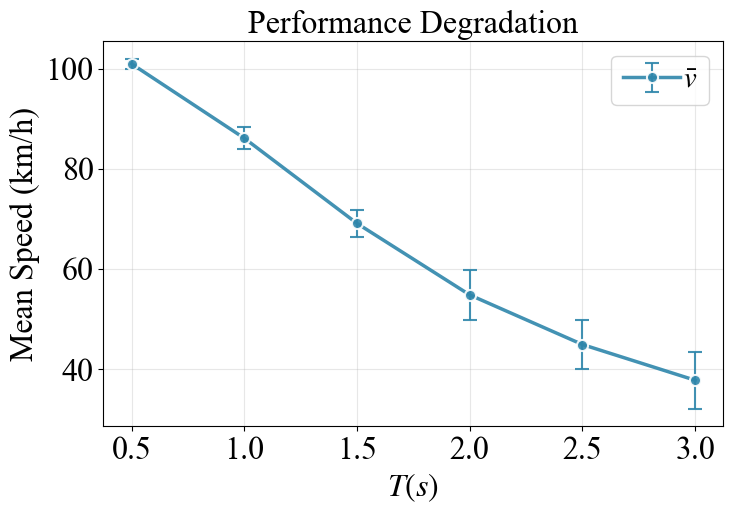

In [22]:
# Speed vs p_slow
plt.figure(figsize=(8, 5))
plt.errorbar(results['T'], 
            results['mean_speed'],
            yerr=results['std_speed'],
            marker='o', capsize=5, capthick=2, linewidth=2.5, markersize=8, elinewidth=1.5,markeredgecolor='white', markeredgewidth=1.5,
            alpha=0.9, color='#2E86AB', label=r'$\bar{v}$')
plt.xlabel(r'$T (s)$')
plt.ylabel('Mean Speed (km/h)')
plt.title('Performance Degradation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('idm_sensitivity.pdf', bbox_inches='tight', facecolor='white')

plt.show()


Plots saved: idm_timegap_sensitivity_results/idm_timegap_2panel_20251115_134757.png


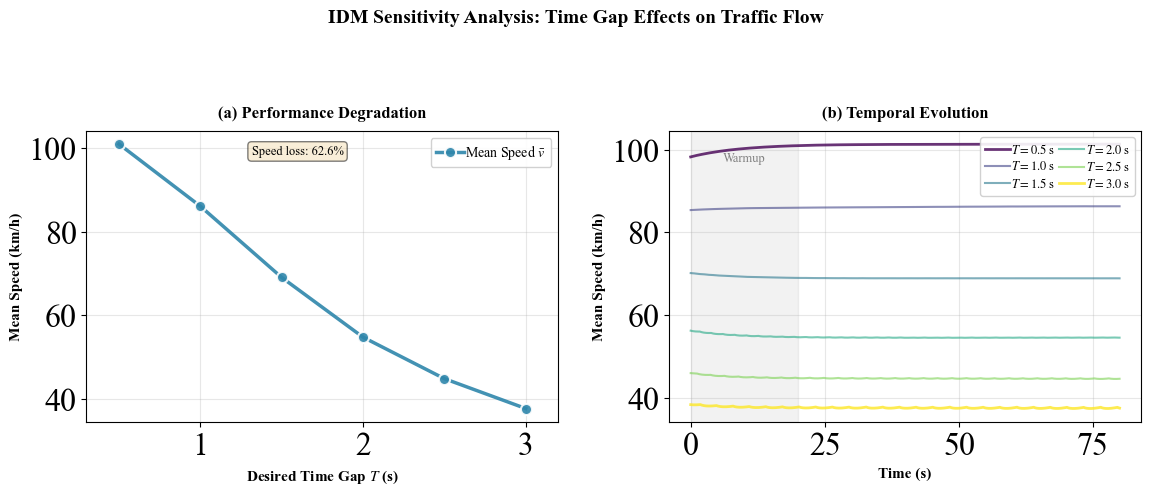

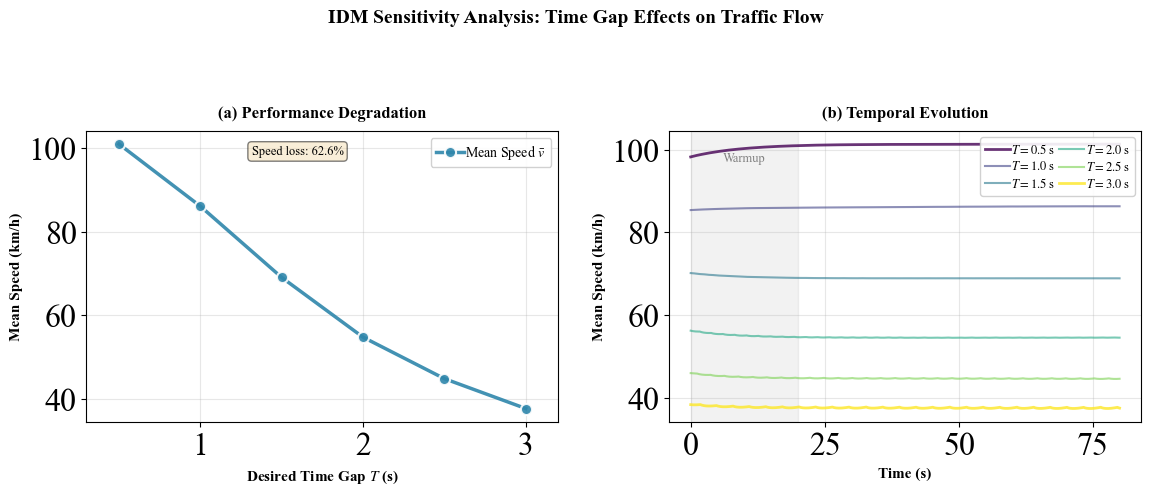

In [21]:
def plot_results_2panel(self, figsize=(12, 5)):
    """Generate 2-panel visualization: Performance + Temporal Evolution."""
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Styling
    marker_style = {
        'marker': 'o',
        'markersize': 8,
        'markeredgecolor': 'white',
        'markeredgewidth': 1.5,
        'linewidth': 2.5,
        'alpha': 0.9
    }
    
    label_style = {'fontsize': 11, 'fontweight': 'bold'}
    title_style = {'fontsize': 12, 'fontweight': 'bold', 'pad': 10}
    
    # ===== Panel (a): Performance Degradation =====
    ax1 = axes[0]
    
    ax1.plot(self.results_df['T'], 
            self.results_df['mean_speed'],
            color='#2E86AB',
            label=r'Mean Speed $\bar{v}$',
            **marker_style)
    
    ax1.set_xlabel(r'Desired Time Gap $T$ (s)', **label_style)
    ax1.set_ylabel('Mean Speed (km/h)', **label_style)
    ax1.set_title('(a) Performance Degradation', **title_style)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    ax1.legend(fontsize=10, frameon=True, framealpha=0.9)
    ax1.set_xlim(self.results_df['T'].min() - 0.2, self.results_df['T'].max() + 0.2)
    
    # Speed loss annotation
    speed_loss = (1 - self.results_df.iloc[-1]['mean_speed'] / 
                  self.results_df.iloc[0]['mean_speed']) * 100
    ax1.text(0.35, 0.95, f'Speed loss: {speed_loss:.1f}%', 
            transform=ax1.transAxes, fontsize=9,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # ===== Panel (b): Temporal Evolution =====
    ax2 = axes[1]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(self.results_df)))
    
    for i, (idx, row) in enumerate(self.results_df.iterrows()):
        time_steps = np.arange(len(row['flow_time_series'])) * 0.1  # Convert to seconds
        ax2.plot(time_steps, row['flow_time_series'],
                label=f'$T={row["T"]:.1f}$ s',
                linewidth=2 if row['T'] in [0.5, 3.0] else 1.5,
                alpha=0.8 if row['T'] in [0.5, 3.0] else 0.6,
                color=colors[i])
    
    ax2.set_xlabel('Time (s)', **label_style)
    ax2.set_ylabel('Mean Speed (km/h)', **label_style)
    ax2.set_title('(b) Temporal Evolution', **title_style)
    ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    ax2.legend(loc='best', fontsize=9, ncol=2, frameon=True, framealpha=0.9)
    
    # Add warmup region
    warmup_end = 20  # seconds
    ax2.axvspan(0, warmup_end, alpha=0.1, color='gray', zorder=0)
    ax2.text(warmup_end/2, ax2.get_ylim()[1]*0.95, 'Warmup', 
            ha='center', va='top', fontsize=9, color='gray')
    
    # Overall title
    fig.suptitle('IDM Sensitivity Analysis: Time Gap Effects on Traffic Flow', 
                fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    fig_path = self.output_dir / f'idm_timegap_2panel_{timestamp}.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(str(fig_path).replace('.png', '.pdf'), bbox_inches='tight', facecolor='white')
    
    print(f"\nPlots saved: {fig_path}")
    plt.show()
    
    return fig

plot_results_2panel(idm_analyzer, figsize=(12, 5))

/var/folders/69/8r8f20y50msgx6r9gzr30fkw0000gn/T/ipykernel_84128/2209917198.py:296: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])



Plots saved: idm_timegap_sensitivity_results/idm_timegap_sensitivity_20251115_133700.png


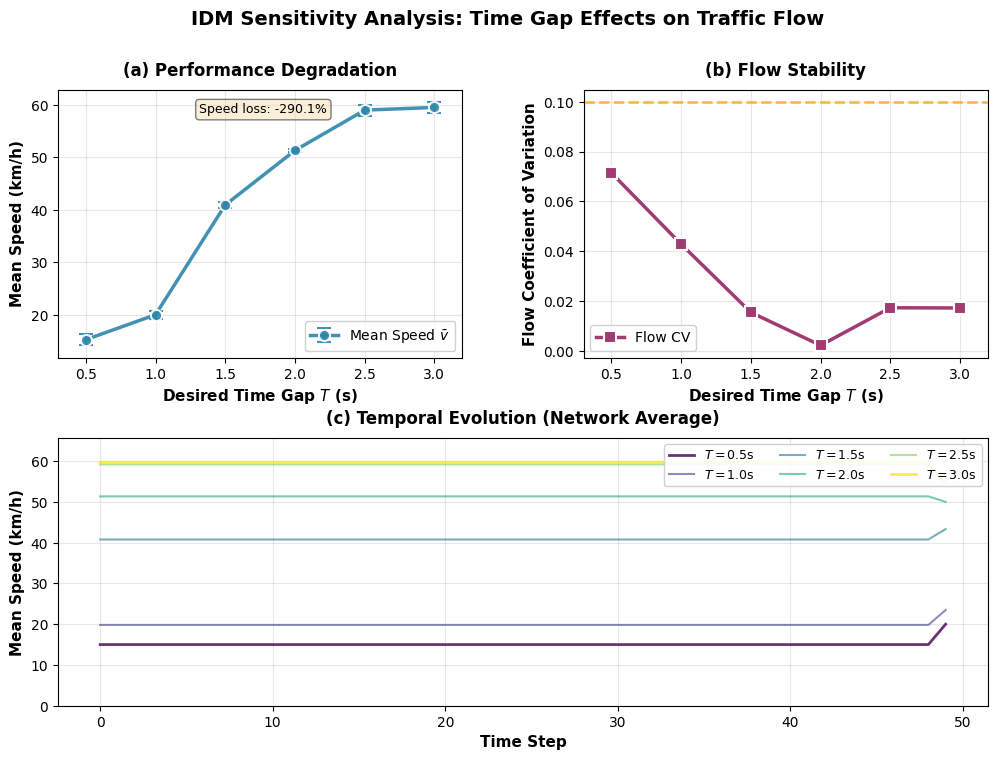

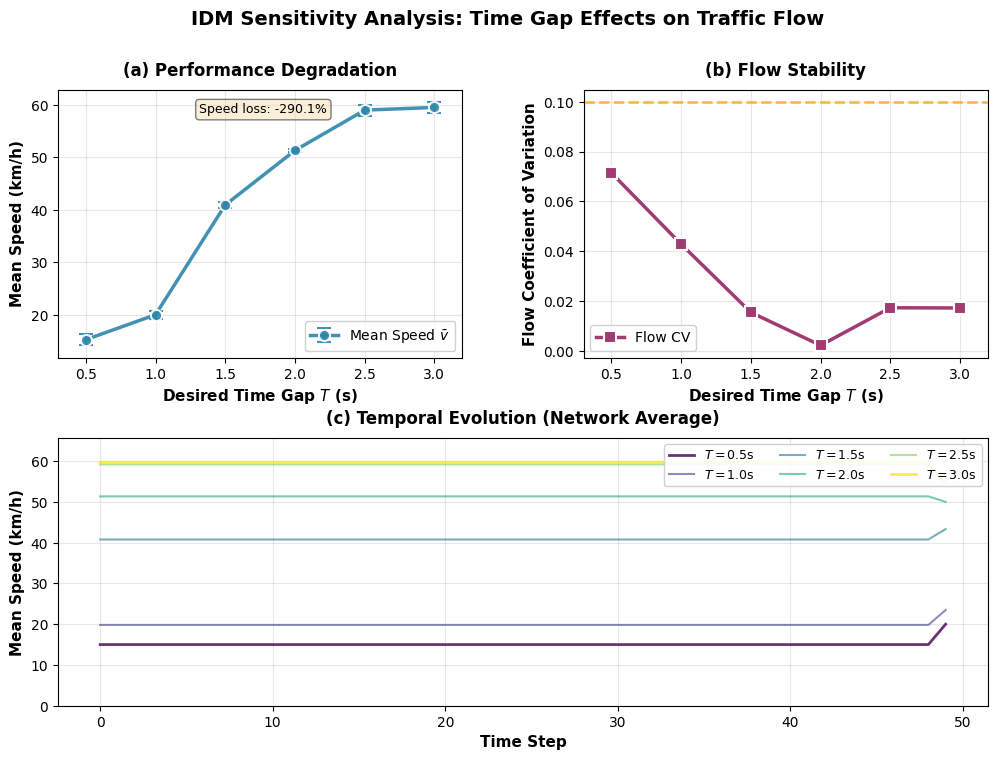

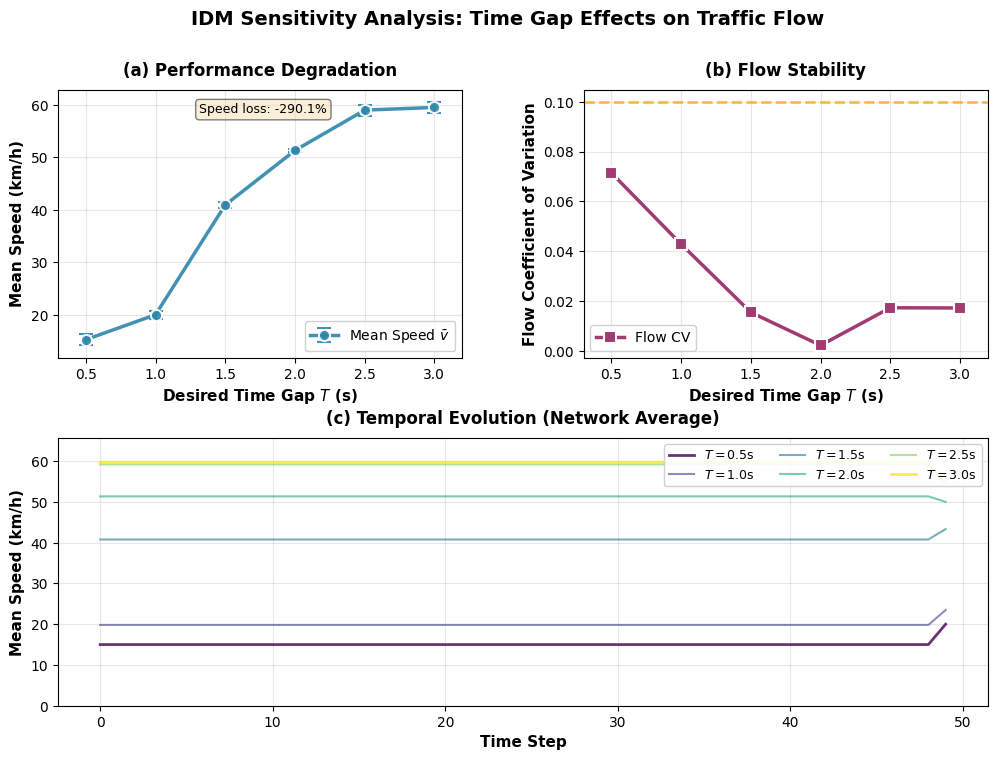

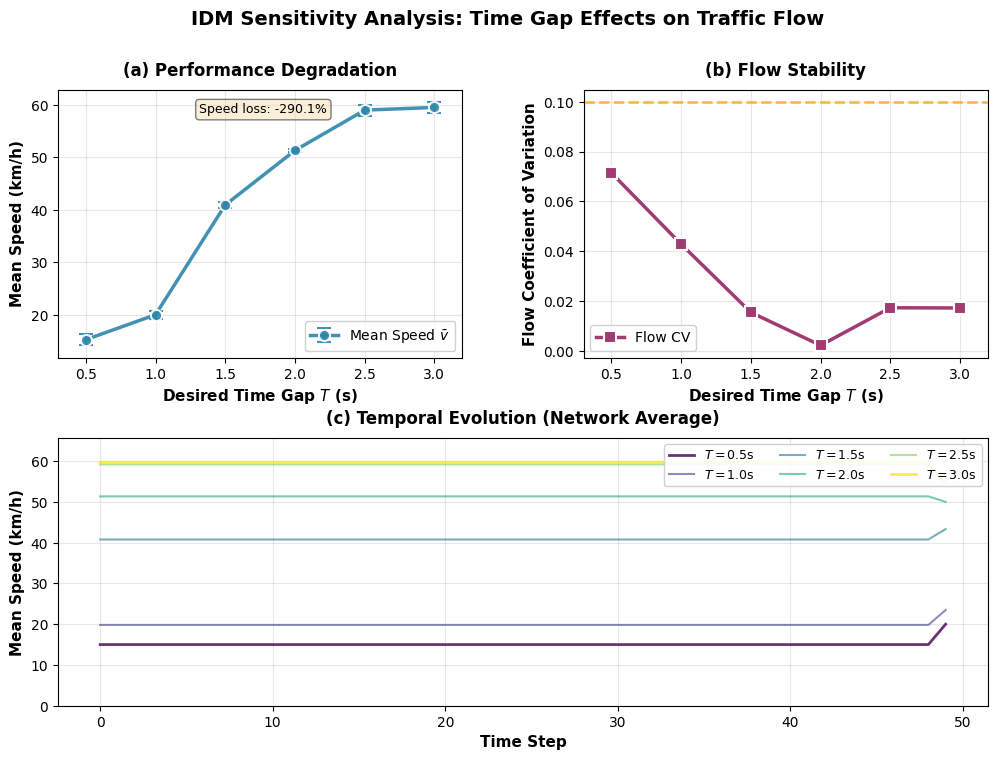

In [11]:
%matplotlib inline
idm_analyzer.plot_results()


In [23]:
results

,T,mean_speed,std_speed,speed_ratio,mean_flow,flow_cv,shockwave_frequency,mean_headway,headway_compliance,v_history_kmh,flow_time_series
0,0.5,100.930123,1.029654,0.934538,0.841084,0.006451,80,2.351529,4.703057,"[[82.679396712704, 102.29586864232292, 77.1898...","[98.21825348866687, 98.25259977466617, 98.2866..."
1,1.0,86.077545,2.246381,0.797014,0.717313,0.002453,80,2.729467,2.729467,"[[64.81844233172639, 84.53780901365559, 91.588...","[85.3919792967743, 85.39943098784087, 85.40738..."
2,1.5,69.058831,2.683477,0.639434,0.575490,0.003776,80,3.448960,2.299306,"[[90.65168147721688, 95.34369511556905, 76.723...","[70.18894315118422, 70.1749119739577, 70.16191..."
3,2.0,54.774867,5.070698,0.507175,0.456457,0.006288,80,4.361215,2.180607,"[[85.45042172714376, 80.14535894791807, 68.908...","[56.29523327291189, 56.26293568929802, 56.2340..."
4,2.5,44.865961,4.887528,0.415426,0.373883,0.005929,80,5.328502,2.131401,"[[92.2724688226512, 98.82547589252879, 83.4586...","[46.053772878222134, 46.040080438971835, 46.02..."
5,3.0,37.731292,5.676255,0.349364,0.314427,0.004854,80,6.253093,2.084364,"[[82.3510011518097, 85.89285131416743, 96.0067...","[38.448367737457794, 38.4358094207609, 38.4253..."
